In [2]:
import torch
names = open('data/names.txt','r').read()
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
t= torch.tensor

In [3]:
SPECIAL = '.'
names = names.replace('\n','.')

chars = sorted(list(set(''.join(names))))
stoi = {s:i for i,s in enumerate(chars)}
itos = {i:s for s,i in stoi.items()}



def label_data(context_size, names):
    X = []
    Y = []
    context = [0] * context_size    

    
    for letter in names + '.':
        letter_as_int = stoi[letter]
        X.append(context)
        Y.append(letter_as_int)
        context = context[1:] + [letter_as_int]
    

    return (X,Y) 

X,Y = label_data(3, names)

def split_data(data):
    data_size = len(data)
    dev_size = int(data_size*0.8)
    tr_size = int(data_size*0.1)
    
    dev = t(data[:dev_size])
    tr = t(data[dev_size:dev_size + tr_size])
    tst = t(data[dev_size+tr_size:])
    
    return (dev,tr,tst)

X_dev,X_tr,X_tst = split_data(X)
Y_dev,Y_tr,Y_tst = split_data(Y)

In [96]:
# let embeding C E R^m, where m = 2, |V| = 27
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 100), generator=g)
B1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
B2 = torch.randn(27, generator=g)
parameters = [C, W1, B1, W2, B2]

params = [C,W1,B1,W2,B2]
print("params count:",sum(p.nelement() for p in parameters))

for p in params:
    p.requires_grad = True

i = 0
lri = []

def step(X,Y,lr):
    global i
    global lri
    ix = torch.randint(0, X.shape[0], (32,))

    emb = C[X[ix]]
    emb_aligned = emb.view(-1,30)
    # layer 1 
    for param in params:
        param.grad = None
    
    layer_1 = torch.tanh(emb_aligned @ W1 + B1)
    layer_2 = layer_1 @ W2 + B2
    loss = torch.nn.functional.cross_entropy(layer_2,Y[ix])
   
    loss.backward()

    for param in params:
        param.data -= lr * param.grad
    
    return loss.item()

def evaluate(X,Y):
    emb = C[X]

    layer_1 = torch.tanh(emb.view(-1,30) @ W1 + B1)
    layer_2 = layer_1 @ W2 + B2
    return torch.nn.functional.cross_entropy(layer_2,Y)



# lre = torch.linspace(-4,0, 1000)
# lrs = 10 ** lre
# for i in range(1000):
#     loss = step(X_dev,Y_dev, lrs[i])
#     lri.append(loss)
# plt.plot(lre,lri)
# => 
lr = 10**-0.5
lossi = []

params count: 6097


tensor(2.4525, grad_fn=<NllLossBackward0>)
tensor(2.8024, grad_fn=<NllLossBackward0>)
tensor(2.8380, grad_fn=<NllLossBackward0>)


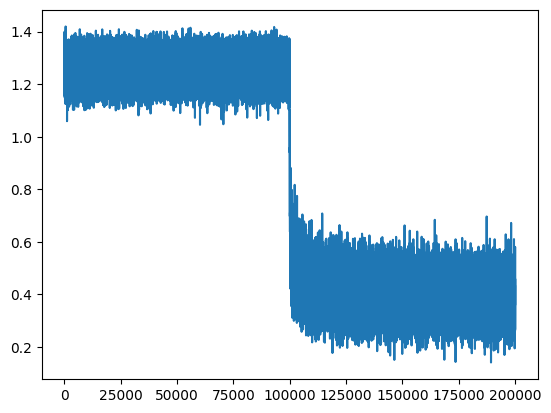

In [98]:
for i in range(100_000):
    loss = step(X_dev, Y_dev, lr)
    lossi.append(torch.log10(torch.tensor([loss])).item())

plt.plot(lossi)
print(evaluate(X_dev,Y_dev))
print(evaluate(X_tr,Y_tr))
print(evaluate(X_tst,Y_tst))


In [99]:
def predict_next_letter(letters):
    emb = C[letters]
    layer_1 = torch.tanh(emb.view(-1,30) @ W1 + B1)
    layer_2 = layer_1 @ W2 + B2
    prob_dist = torch.nn.functional.softmax(layer_2,dim=1)
    next_letter = torch.multinomial(prob_dist, num_samples=1).item()
    return next_letter

def s_to_i(letters):
   return list(map(lambda l: stoi[l],letters))


for i in range(20):
   letters = s_to_i(['.','.','.'])
   letters_tensor = t(letters)
   predicted = []

   while True:
      predicted_letter_index = predict_next_letter(letters_tensor)
      if predicted_letter_index == 0:
         break
      predicted.append(predicted_letter_index)
      letters = letters[1:] + [predict_next_letter]

   name = "".join(list(map(lambda i: itos[i],predicted)))
   print(f'{len(name)=}')
      




KeyboardInterrupt: 